# MODIS Water Random Forest

Version: 0.2.1

Date modified: 03.23.2022

Modified by: Caleb Spradlin

In [46]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import os
import sys
import csv
import time
import glob
import joblib
import datasets
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

#sys.path.append('../')
#import notebook_util as nu

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [48]:
FIGURE_OUTPUT_DIR = 'output'
RASTER_OUTPUT_DIR = 'output'
MODEL_OUTPUT_DIR = 'models'

training_data_basepath = 'v4.2.0'
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'


qaMaskPath = 'qa'
waterMaskPath = 'v5_outputs'

test_data_basepath = 'test_data'

GPU = True
TILE = 'Golden'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = [] # ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [49]:
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

In [50]:
colsToDrop

[]

In [51]:
colsToDropTraining

['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

## Data 
- Read in to cuDF or pandas Dataframe
- Drop unnecessary columns
- Clean data
- Split into Xs and Ys
- Train-test split

In [52]:
#glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
#data_paths = [fv for fv in glob.glob(glob_string)]
#data_path = data_paths[0]
#pprint(data_paths)

In [53]:
%%time

#X_train, X_test, y_train, y_test = load_data(fpath=data_path,
#                                             colsToDrop=colsToDropTraining,
#                                             dataType=DATA_TYPE,
#                                             cpu=True,
#                                             splitXY=True,
#                                             imbalance=False,
#                                             trainTestSplit=True,
#                                             multi=False)
train_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='train'))
test_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='test'))
X_train, y_train = train_dataset.drop(['water'], axis=1), train_dataset['water']
X_test, y_test = test_dataset.drop(['water'], axis=1), test_dataset['water']
X_train.shape, X_test.shape

CPU times: user 319 ms, sys: 17.3 ms, total: 336 ms
Wall time: 1.75 s


((800, 10), (200, 10))

In [54]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [55]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [56]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1209.75875,1287.886517,8.0,238.25,886.5,1893.25,9222.0
sur_refl_b02_1,800.0,1577.25375,1554.828794,1.0,168.00,1394.0,2667.75,8837.0
sur_refl_b03_1,800.0,743.00000,1004.334475,-100.0,286.00,540.0,857.00,8909.0
sur_refl_b04_1,800.0,1028.39500,1065.582946,6.0,413.00,809.5,1313.25,9162.0
sur_refl_b05_1,800.0,1969.37125,1467.613243,-92.0,553.50,1818.5,3210.75,6382.0
sur_refl_b06_1,800.0,1932.65875,1541.910775,51.0,511.25,1498.5,3254.25,6610.0
sur_refl_b07_1,800.0,1587.69625,1395.266352,0.0,316.75,1174.0,2672.00,6128.0
ndvi,800.0,87.13125,2518.736818,-9493.0,-1533.00,733.5,1729.50,8587.0
ndwi1,800.0,-2336.03750,3404.038705,-9862.0,-4577.50,-1582.0,-766.50,8823.0
ndwi2,800.0,-914.29125,3863.695634,-9692.0,-2846.25,-703.5,869.00,10000.0


In [57]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [58]:
output_interesting_idx(X_train, 'ndvi', 1000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,2031,3113,776,1200,3626,3480,2957,2103,-556,257
2,1609,2615,797,1000,2143,1708,1107,2381,2098,4051
3,2593,3315,1250,1944,3923,4194,3909,1222,-1170,-822
4,2485,3365,905,1527,4520,4646,4137,1504,-1599,-1029
9,1388,2005,548,852,2433,2413,2210,1818,-923,-486
...,...,...,...,...,...,...,...,...,...,...
789,1949,2626,829,1344,3309,3651,3100,1479,-1632,-827
794,2214,3229,877,1384,3575,3278,2754,1864,-75,793
795,1894,2404,1082,1473,2926,3031,2433,1186,-1153,-59
798,1907,2817,622,1004,3616,3755,3250,1926,-1427,-713


# Model definition and training

In [59]:
hyperparameters = {'n_estimators': 400, 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                  }

In [60]:
classifier = skRF(**hyperparameters)

In [61]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321
 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 

In [62]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.99375
Best accuracy score: 1.0


## Regular fitting

In [63]:
classifier = skRF(**hyperparameters)

In [64]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 1.48 s, sys: 26.6 ms, total: 1.5 s
Wall time: 2.21 s


RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)

## Model testing and training/testing data validation

### Get model metrics

In [65]:
classifier = bestModel

In [66]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.98

In [67]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [68]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

### Show the distribution of the probability of the predicted values.

These are the probability that each test data point is water p=1 vs land p=0. Usually a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

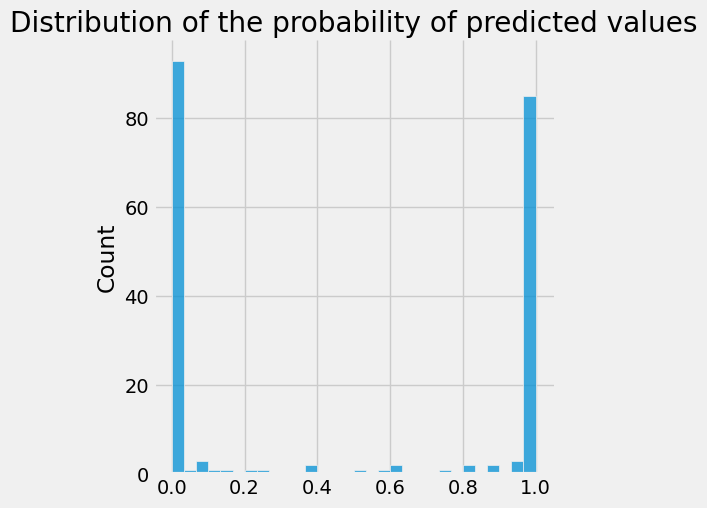

In [69]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [70]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

In [71]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       105
           1       0.97      0.99      0.98        95

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

Test Recall
-------------------------------------------------------
0.9714285714285714
Confusion Matrix
-------------------------------------------------------
[[102   3]
 [  1  94]]


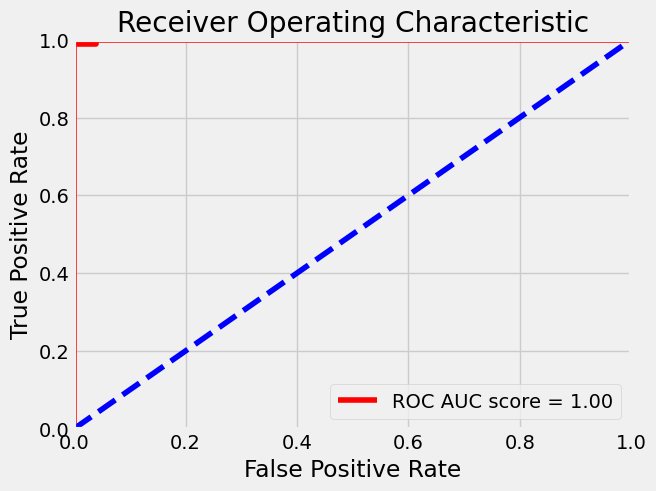

In [72]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Permutaion importance

In [73]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 8.91 s, sys: 722 ms, total: 9.63 s
Wall time: 13.7 s


Text(0.5, 0, 'Permutation Importance')

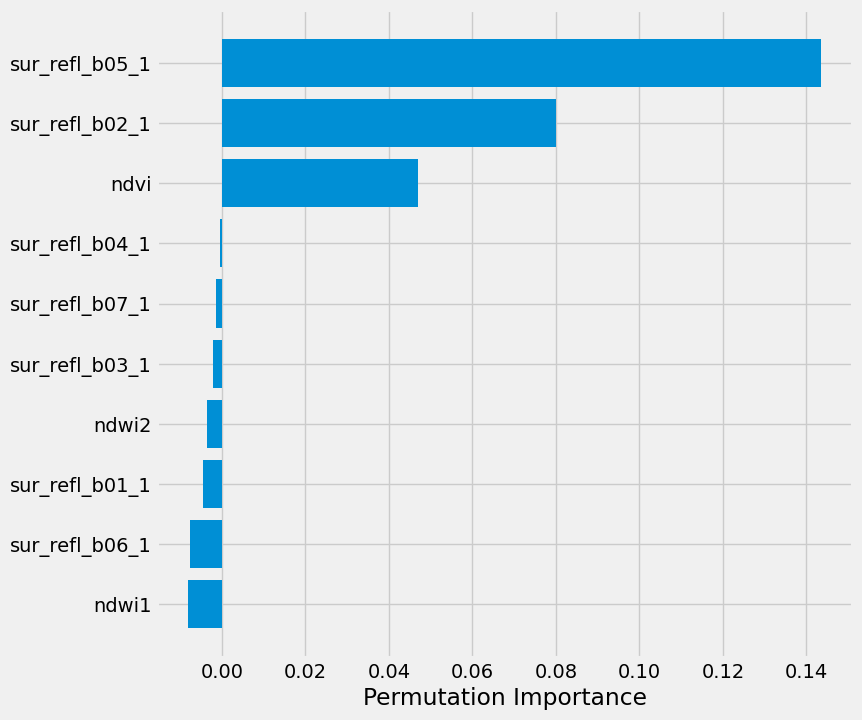

In [74]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
# plt.savefig(png_save_path)

Garbage collection

In [75]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [76]:
model_save_path = 'mw_{}_{}_{}_{}_{}_2.0.0_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: models/mw_Golden_0.98_400_rf_cpu_2.0.0_tuned_2023_04_09_19_33.sav
RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)


['models/mw_Golden_0.98_400_rf_cpu_2.0.0_tuned_2023_04_09_19_33.sav']

# Testing: raster testing

In [77]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

ModuleNotFoundError: ignored

In [ ]:
TILE = 'h11v10'
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [ ]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

In [ ]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [ ]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [ ]:
%%time
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

In [ ]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [ ]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

## Inputreshapet raster: description and histogram

In [ ]:
df.describe().T

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [ ]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [ ]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [ ]:
maskedResult = np.where(qa_mask == 0, reshp, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

In [ ]:
plt.matshow(waterMasked)

# Generating stats for predicted and truth

## Predicted Raster

In [ ]:
import math

In [ ]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

In [ ]:
countNoData = np.count_nonzero(maskedResult == 255)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

In [ ]:
countNoDataT = np.count_nonzero(waterMasked == 255)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

### Model metrics on raster data

In [ ]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

## Output predicted raster to GeoTiff

In [ ]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

In [ ]:
import folium
from folium import plugins
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [ ]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [ ]:
outPath

In [ ]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

In [ ]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [ ]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())